<img src="escuela-de-economia.png" width="260" height="60">
<center>
    <b>EC4301 MACROECONOMETRÍA</b><br>
    <b>Profesor:  Randall Romero Aguilar, PhD</b>
<br><br>
<b>Laboratorio:</b>
<div style="font-size:175%;color:white; background-color: #0064b0;">Tema 10: Vectores autorregresivos (VAR)</div>
<div style="font-size:250%;color:white; background-color: #0064b0;">Estimador OLS del VAR(1) es consistente e insesgado</div> 
</center>
<i>Creado:     2017-May-16 
    <br>
    Actualizado: 2020-Oct-25</i>

# Pasos iniciales

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
from statsmodels.tsa.api import VAR

np.random.seed(1995)

%matplotlib inline 

# Estimador OLS del VAR(1) es consistente e insesgado

## EL MODELO

En este cuaderno simulamos realizaciones del VAR(1)

\begin{align*} 
x_t &= 0.8x_{t-1} + 0.7y_{t-1} + \epsilon_{x,t} \\
y_t &= -0.2x_{t-1} + 0.5y_{t-1} + \epsilon_{y,t}
\end{align*}

que puede escribirse
$$
\underset{Y_t}{\begin{pmatrix}x_t \\ y_t\end{pmatrix}} = 
\underset{\Phi}{\begin{pmatrix}0.8 & 0.7 \\ -0.2 & 0.5\end{pmatrix}}
\underset{Y_{t-1}}{\begin{pmatrix}x_{t-1} \\ y_{t-1}\end{pmatrix}} +
\underset{\epsilon_t}{\begin{pmatrix}\epsilon_{x,t} \\ \epsilon_{y,t}\end{pmatrix}}
\quad\qquad
\Omega = \begin{pmatrix}0.9 & 0 \\ 0 & 0.9\end{pmatrix}
$$


y las utilizamos para estimar los párametros originales por OLS. El objetivo es ilustrar que este estimador está insesgado y que es consistente.

### Funciones auxiliares

Definimos las matrices de parámetros $\Phi$ y $\Omega$. Declaramos dos funciones: para simular una muestra de observaciones del VAR, y otra para estimar los coeficientes de $\Phi$ a partir de tales simulaciones. 

In [2]:
A = np.array([[0.8, 0.7], [-0.2, 0.5]])
sigma = 0.9

def var_sample(T = 100):
    ''' Simula el VAR(1) T períodos'''
    X = np.zeros((T,2))
    for t in range(1, T):
        X[t] = X[t-1] @ A.T + sigma * np.random.randn(2)
    
    trimestres = pd.date_range(start='1992q1',freq='d',periods=T)
    return pd.DataFrame(X, columns=['precio', 'cantidad'],index=trimestres)

def A_ols(data):
    '''Estima un VAR(1) a partir de datos, retorna coeficientes como vector'''
    return VAR(data).fit().coefs[0].flatten()

##  La estimación OLS de un VAR es insesgada

Obtenemos 10000 muestras de $T=100$ observaciones del VAR. Para cada muestra estimamos el VAR y colectamos los coeficientes estimados.

In [3]:
%%time
nrepetitions = 10000
estimates = pd.DataFrame([A_ols(var_sample()) for k in range(nrepetitions)],
                         columns=['$Φ_{11}$', '$Φ_{21}$', '$Φ_{12}$', '$Φ_{22}$'])

Wall time: 42 s


In [4]:
estimates.head()

,$Φ_{11}$,$Φ_{21}$,$Φ_{12}$,$Φ_{22}$
0,0.691685,0.679327,-0.276123,0.428017
1,0.779543,0.763695,-0.186702,0.584590
2,0.827301,0.837952,-0.278445,0.444311
3,0.826135,0.791333,-0.343680,0.382260
4,0.819778,0.615994,-0.153597,0.315891


Luego graficamos la distribución de cada columna (estimaciones de uno de los parámetros) con un histograma. Observe cómo la distribución estimada está centrada alrededor del verdadero parámetro en cada uno de los gráficos.

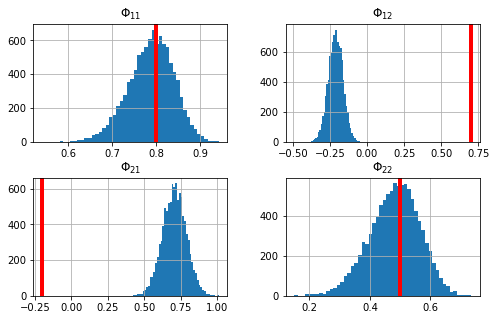

In [5]:
ax = estimates.hist(bins=50,figsize=[8,5])

for i in range(2):
    for j in range(2):
        ax[i,j].axvline(x=A[i,j],linewidth=4, color='r')
        
#plt.gcf().savefig('imag/var-insesgado.pdf',bbox_inches='tight')        

##  La estimación OLS de un VAR es consistente

Para ilustrar que la estimación OLS de un VAR es consistente, simulamos una sola muestra de datos y vamos agregando una nueva observación. En cada paso estimamos el VAR con OLS. Observe que conforme aumenta el número de observaciones, los valores estimados convergen a los parámetros poblacionales.

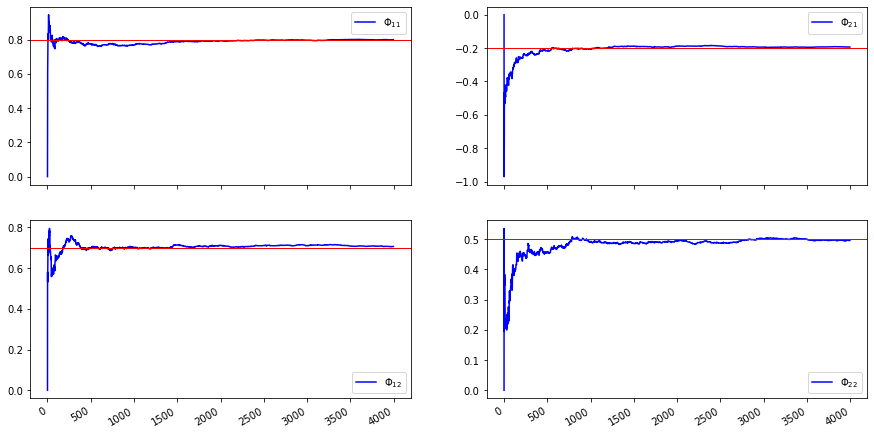

In [6]:
xlag = np.zeros([2,1])
XpX = np.zeros([2,2])
XpY = np.zeros([2,2])

T = 4000
minT = 4
Xest = np.zeros([T+1, 4])

for t in range(T+1):
    x = A @ xlag + sigma * np.random.randn(2,1)
    XpX += np.outer(xlag, xlag)
    XpY += np.outer(xlag, x)
    xlag = x.copy()
    
    if t>minT:
        Xest[t] = np.linalg.solve(XpX/t, XpY/t).flatten()
    
    
estimates2 = pd.DataFrame(Xest[minT:], columns=['$Φ_{11}$', '$Φ_{21}$', '$Φ_{12}$', '$Φ_{22}$'])

ax = estimates2.plot(color='b',figsize=[15,8],subplots=True, layout=[2,2])

for i in range(2):
    for j in range(2):
        ax[i,j].axhline(y=A[j,i],linewidth=1, color='r')

#plt.gcf().savefig('imag/var-consistente.pdf',bbox_inches='tight') 